In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import itertools
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
# Import the stopwords from NLTK this will help us to filter the most significant words.
nltk.download('stopwords')
pd.options.display.max_colwidth = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlos_barron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Data Load
news_train = pd.read_csv('./data/bbc_news_classification_kaggle/bbc_news_train.csv')
news_test = pd.read_csv('./data/bbc_news_classification_kaggle/bbc_news_test.csv')
documents_train = news_train['Text']
labels_train = news_train['Category']
documents_test = news_test['Text']

# EDA

In [3]:
n_samples = news_train.shape[0]
n_samples

1490

In [4]:
news_train.sample(5)

,ArticleId,Text,Category
734,1008,child access law shake-up planned parents who refuse to allow former partners contact with their...,politics
627,956,india and iran in gas export deal india has signed a $40bn (£21bn) deal to import millions of to...,business
507,1858,parliament s record of scandal in a locked room at the heart of parliament there is a hive of sc...,politics
771,176,chinese exports rise 25% in 2004 exports from china leapt during 2004 over the previous year as ...,business
937,706,eastenders is set for us remake plans to create a us soap based on the bbc s eastenders have r...,entertainment


### Categories

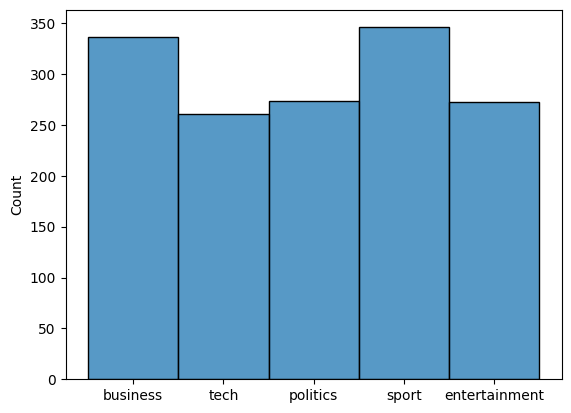

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [5]:
categories_count = news_train['Category'].value_counts()
categories = np.unique(news_train['Category'].values)
sns.histplot(news_train['Category'].values)
plt.show()
categories_count

### Data Cleansing
1. Collect english stopwords from the NLTK library.
2. Remove stopwords from all training documents.
3. Get list of most repeated word by document to be used later for the wordcloud.

In [6]:
stopwords = nltk.corpus.stopwords.words('english') #+ ['us', 'mr', 'said']
documents_train_wo_stopwords = [[re.sub(' +', '', re.sub('[^A-Za-z0-9]+', '', word)).strip() for word in doc.split() if word not in stopwords] for doc in documents_train]
docs_most_common_word = [Counter([re.sub(' +', ' ', re.sub('[^A-Za-z0-9]+', '', word)).strip() for word in doc.split() if word not in stopwords]).most_common(1)[0][0] for doc in documents_train]
documents_train_wo_stopwords = pd.DataFrame([' '.join(doc) for doc in documents_train_wo_stopwords])
documents_test_wo_stopwords = [[re.sub(' +', '', re.sub('[^A-Za-z0-9]+', '', word)).strip() for word in doc.split() if word not in stopwords] for doc in documents_test]
documents_test_wo_stopwords = pd.DataFrame([' '.join(doc) for doc in documents_test_wo_stopwords])
documents_train_wo_stopwords.sample(5)

,0
55,blair buys copies new band aid prime minister tony blair purchased two copies charity single ban...
385,robinson six nations england captain jason robinson miss rest six nations injury robinson standi...
1230,lowbudget film wins cesar film follows group alienated youth paris suburb prepare perform 18th c...
1450,standard life concern lse bid standard life latest shareholder deutsche boerse express concern g...
898,apple mac mini gets warm welcome mac mini welcomed apple fans industry experts pc users release ...


### Word Statistics by Document
The length of the documents is pretty diverse.

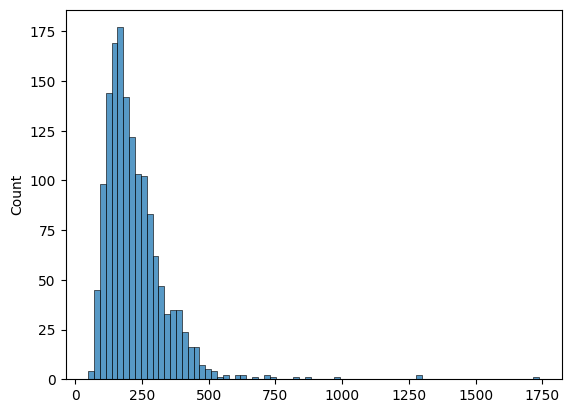

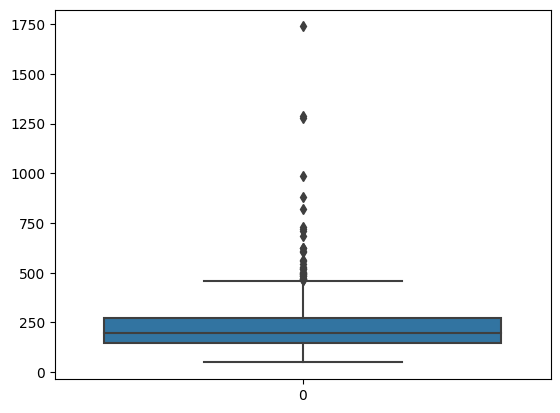

,count,mean,std,min,25%,50%,75%,max
0,1490.0,222.777181,116.51924,49.0,147.0,197.5,272.75,1738.0


In [7]:
word_counts = [d.count(' ') + 1 for d in documents_train_wo_stopwords[0]]
sns.histplot(word_counts)
plt.show()
sns.boxplot(word_counts)
plt.show()
pd.DataFrame(word_counts).describe().T

### Wordcloud
It's very interesting to see the most common words across all of the documents.

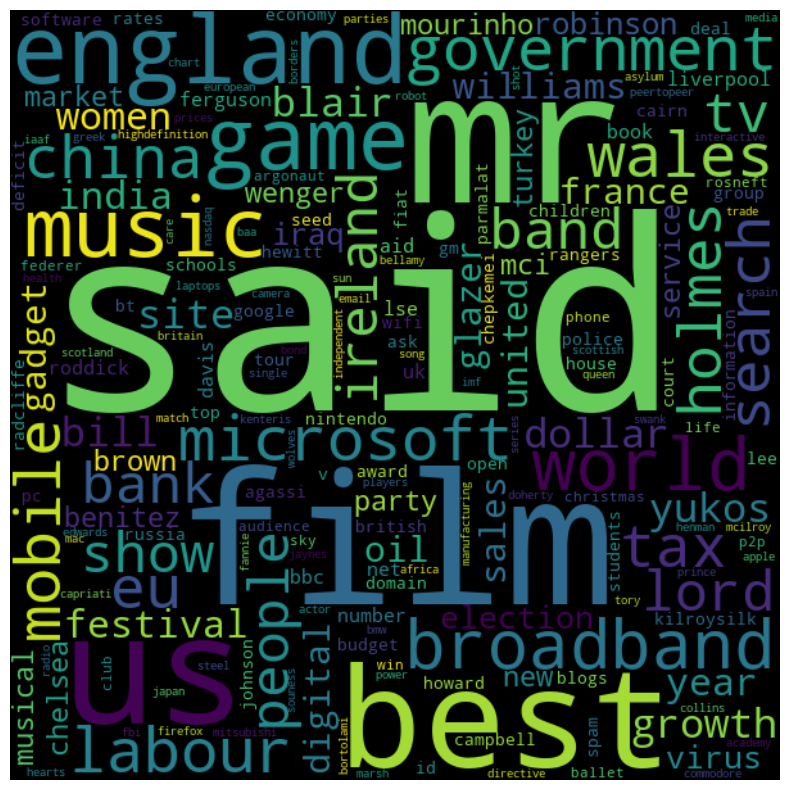

In [8]:
wordcloud = WordCloud(width=600, height=600).generate(' '.join(docs_most_common_word))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [9]:
news_train['most_common_word'] = docs_most_common_word
news_train.sample(5)

,ArticleId,Text,Category,most_common_word
1174,346,clijsters could play aussie open kim clijsters has denied reports that she has pulled out of jan...,sport,open
601,289,brown targets oaps and homebuyers gordon brown has doubled the level at which house buyers pay s...,politics,tax
1428,120,chelsea sack mutu chelsea have sacked adrian mutu after he failed a drugs test. the 25-year-old...,sport,chelsea
280,65,india power shares jump on debut shares in india s largest power producer national thermal powe...,business,power
459,1383,more movies head to sony s psp movies open water and saw are among those to be made available fo...,tech,movies


# Feature Extraction
Using sklearn's TfidfVectorizer (Term frequency–inverse document frequency) I will create a vector to collect the most frequent words to compute their occurrences. After testing different parameters the following configuration yielded the best results:
- min_df: Minimum threshold to ignore vocabulary terms based on document frequency.
- max_df: Maximum threshold to ignore vocabulary terms based on document frequency.
- ngram_range: Option (1,1), is for using only unigrams. An n-gram is a contiguous sequence of n items from a given sample of text.
- stopwords: Common words, such as articles, prepositions, conjunctions, and pronouns.

In general TFIDF will provide us with a numerical value to explain how important each word is to each corresponding document.

For the NMF I tried different init values nndsvda gave the best result.
- The init parameter sets the initialization procedure.

In [10]:
# Vectorizer using documents as provided, without any cleansing.
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_train)

In [11]:
nmf = NMF(n_components=len(categories_count), init='nndsvda')
W = nmf.fit_transform(X)
H = nmf.components_

In [12]:
H.shape

(5, 5511)

In [13]:
categories

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [14]:
words = vectorizer.get_feature_names_out()
words

array(['000m', '05', '100', ..., 'zero', 'zone', 'zurich'], dtype=object)

After using the Non-Negative Matrix Factorization method, we have two resulting matrices W and H, that are decomposed from the initial matrix X (TFIDF resulting sparse matrix). 

Below, we can see the 10 most relevant words from each topic. The NMF parameter "number of components" should match the number of categories (business, entertainment, politics, sport, tech) that we want to classify the documents by.

We get the weight of each word by category (topic) from the matrix H, with 5 sorted vectors of weights, and map to the indexes of the features of the tfidf vectorizer.

Then get the argmax of each topic weight from matrix W. This will be our predicted topic, which is numerical, we manually provide the label by briefly analizing the n most important words of each topic or match it using the precision metric that gives the best result (function get_labels below).

Since we are using an unsupervised learning approach, the test dataset will not use any inference from a previous training dataset.

In [15]:
[f'Topic {idx+1}: '+' '.join([words[weight] for weight in weights.argsort()[-10:]]) for idx, weights in enumerate(H)]

['Topic 1: injury season match france club side chelsea ireland cup wales',
 'Topic 2: lib tories tory chancellor tax prime howard party brown blair',
 'Topic 3: broadband net microsoft software digital phones users technology phone mobile',
 'Topic 4: shares rates prices dollar china oil economic sales bank economy',
 'Topic 5: album festival films star oscar band actress actor award awards']

In [16]:
predicted_unlabeled_topics = np.argmax(W, axis=1)+1
predicted_unlabeled_topics

array([4, 4, 4, ..., 4, 3, 3])

In [17]:
def get_labels(y_true, pred_idx, manual_idx=None):
    if manual_idx:
        y_pred = np.vectorize(manual_idx.get)(pred_idx)
        score = accuracy_score(y_true, y_pred)
        return (round(score*100,2), y_pred)
    else:
        permutated_labels = list(itertools.permutations(categories))
        dics = [ {1:l[0], 2:l[1], 3:l[2], 4:l[3], 5:l[4]} for l in permutated_labels]
    best = 0
    result = None
    for dic in dics:
        y_pred = np.vectorize(dic.get)(pred_idx)
        score = accuracy_score(y_true, y_pred)
        if score > best:
            best = score
            result = y_pred
    score = best
    return (round(score*100,2), result)

In [18]:
# Providing a dictionary manually
score, ypred = get_labels(
    labels_train, 
    predicted_unlabeled_topics, 
    manual_idx={1:'sport',2:'politics',3:'tech',4:'business',5:'entertainment'}
)
score

95.77

In [19]:
#Matching against the true labels and getting the best accuracy result.
score, y_pred = get_labels(labels_train, predicted_unlabeled_topics)
score

95.77

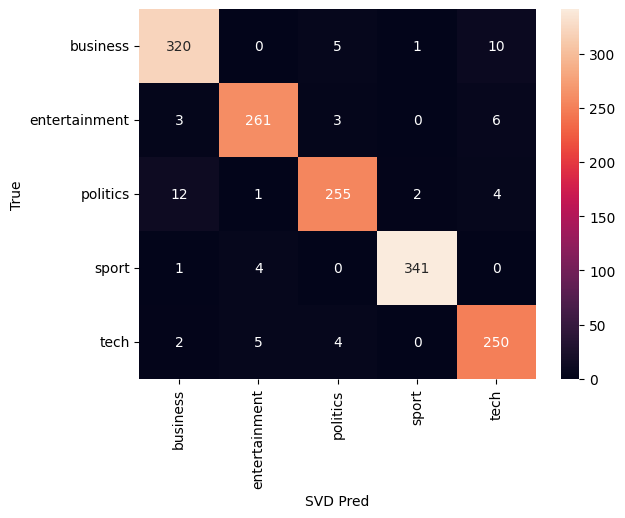

In [20]:
cm = confusion_matrix(labels_train, y_pred)
sns.heatmap(cm, xticklabels=categories, yticklabels=categories,annot=True, fmt='d')
plt.xlabel('SVD Pred')
plt.ylabel('True')
plt.show()

The accuracy of the model with uncleansed documents for the training data is 0.9577

## Using the cleansed training data

In [21]:
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_train_wo_stopwords[0])
nmf = NMF(n_components=len(categories_count), init='nndsvda')
W = nmf.fit_transform(X)
H = nmf.components_
words = vectorizer.get_feature_names_out()
predicted_unlabeled_topics = np.argmax(W, axis=1)+1
[f'Topic {idx+1}: '+' '.join([words[weight] for weight in weights.argsort()[-10:]]) for idx, weights in enumerate(H)]

['Topic 1: broadband net microsoft software phones digital users technology phone mobile',
 'Topic 2: tories tory chancellor prime tax howard party brown election blair',
 'Topic 3: match season coach france club side chelsea ireland cup wales',
 'Topic 4: shares rates prices dollar china oil sales economic bank economy',
 'Topic 5: oscar album star festival films actress band actor award awards']

In [22]:
score, ypred = get_labels(
    labels_train, 
    predicted_unlabeled_topics, 
    manual_idx={1:'tech',2:'politics',3:'sport',4:'business',5:'entertainment'}
)
score

94.36

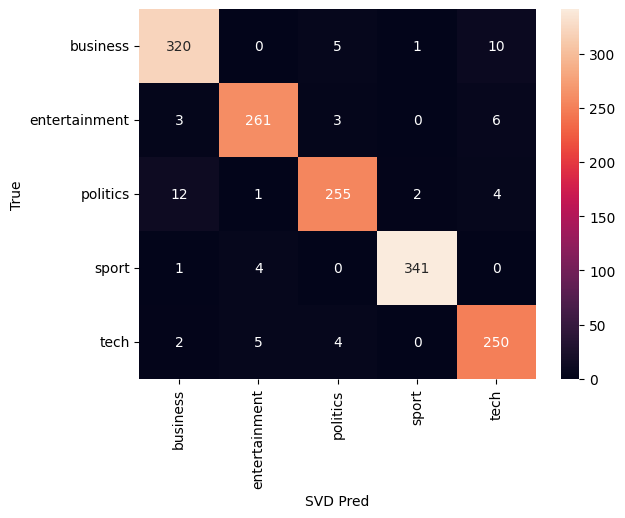

In [23]:
cm = confusion_matrix(labels_train, y_pred)
sns.heatmap(cm, xticklabels=categories, yticklabels=categories,annot=True, fmt='d')
plt.xlabel('SVD Pred')
plt.ylabel('True')
plt.show()

The accuracy of the model with cleansed documents for the training data is 0.9436

Using the cleansed documents without stopwords did not permorm any better.

In [24]:
# Test dataset
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_test_wo_stopwords[0])
nmf = NMF(n_components=len(categories_count), init='nndsvda')
W = nmf.fit_transform(X)
H = nmf.components_
words = vectorizer.get_feature_names_out()
predicted_unlabeled_topics = np.argmax(W, axis=1)+1
[f'Topic {idx+1}: '+' '.join([words[weight] for weight in weights.argsort()[-10:]]) for idx, weights in enumerate(H)]

['Topic 1: broadband net phone computer software games users music digital mobile',
 'Topic 2: leader tories tax tory prime chancellor howard brown election blair',
 'Topic 3: france side coach match injury rugby ireland cup wales club',
 'Topic 4: rate shares rise china economic oil prices sales bank economy',
 'Topic 5: nominations star actress band prize album festival music award awards']

In [25]:
y_pred = np.vectorize({1:'tech',2:'politics',3:'sport',4:'business',5:'entertainment'}.get)(predicted_unlabeled_topics)
y_pred = pd.DataFrame(y_pred, columns=['Category']).Category
y_pred

0              sport
1               tech
2              sport
3           business
4              sport
           ...      
730         business
731    entertainment
732             tech
733         business
734         politics
Name: Category, Length: 735, dtype: object

In [26]:
y_pred = pd.DataFrame(y_pred, columns=['Category']).Category
y_pred.index = news_test['ArticleId']
y_pred.to_csv('./data/bbc_news_classification_kaggle/unsupervised_predicted.csv')

# Supervised Appproach
Using Naive Bayes, this method is very efficient, it works very well with low amount of data, and it works better with categorical data compared to numerical values.
Below we can see a comparisson of different training data sizes. Smaller test sizes (10%) worked best.

In [35]:
vectorizer = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
X = vectorizer.fit_transform(documents_train)
X.shape, labels_train.shape

((1490, 5511), (1490,))

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,labels_train, test_size=0.1)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train,Y_train)
y_pred = naive_bayes.predict(X_test)
round(accuracy_score(Y_test, y_pred)*100,2)

98.66

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,labels_train, test_size=0.2)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train,Y_train)
y_pred = naive_bayes.predict(X_test)
round(accuracy_score(Y_test, y_pred)*100,2)

96.64

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X,labels_train, test_size=0.5, random_state=1984)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train,Y_train)
y_pred = naive_bayes.predict(X_test)
round(accuracy_score(Y_test, y_pred)*100,2)

96.51

In [40]:
print(documents_train_wo_stopwords.shape[0],documents_test_wo_stopwords.shape[0])
documents_test_wo_stopwords.shape[0]+documents_train_wo_stopwords.shape[0]

1490 735


2225

In [42]:
frames = [documents_test,documents_train]
all_docs = pd.concat(frames)
vectorizer_u = TfidfVectorizer(min_df=7, max_df=0.1,ngram_range=(1,1))
Xu = vectorizer_u.fit_transform(all_docs)
Xu_train = Xu[:documents_train_wo_stopwords.shape[0]]
Xu_test = Xu[documents_train_wo_stopwords.shape[0]:]

In [43]:
naive_bayes = MultinomialNB()
naive_bayes.fit(Xu_train,labels_train)
y_pred_u = naive_bayes.predict(Xu_test)
y_pred_u = pd.DataFrame(y_pred_u, columns=['Category']).Category
y_pred_u.index = news_test['ArticleId']
y_pred_u.to_csv('./data/bbc_news_classification_kaggle/supervised_predicted.csv')
y_pred_u

ArticleId
1018       sport
1319    business
1138       sport
459     business
1020       sport
          ...   
1923    business
373        sport
1704       sport
206        sport
471        sport
Name: Category, Length: 735, dtype: object

In [44]:
news_test

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on ...
1,1319,software watching while you work software that can not only monitor every keystroke and action p...
2,1138,d arcy injury adds to ireland woe gordon d arcy has been ruled out of the ireland team for satur...
3,459,india s reliance family feud heats up the ongoing public spat between the two heirs of india s b...
4,1020,boro suffer morrison injury blow middlesbrough midfielder james morrison has been ruled out for ...
...,...,...
730,1923,eu to probe alitalia state aid the european commission has officially launched an in-depth inv...
731,373,u2 to play at grammy awards show irish rock band u2 are to play live at the grammy awards presen...
732,1704,sport betting rules in spotlight a group of mps and peers has called for a tightening of regulat...
733,206,alfa romeos to get gm engines fiat is to stop making six-cylinder petrol engines for its sport...
